In [24]:
import sys

import pandas as pd

from subpred.transporter_dataset import create_dataset
from subpred.eval import full_test, get_independent_test_set, preprocess_pandas, optimize_hyperparams
from subpred.compositions import calculate_aac, calculate_paac
from subpred.pssm import calculate_pssms_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

LOG_FILE = "../logs/athaliana_amino_sugar_potassium.log"

This notebook contains the evaluation of a thaliana with four different substrates, after removing potential additional Electron transport outliers.

In [25]:
sodium = ["Q2UVJ5", "O04034", "Q9FKP1", "Q9LJI2", "Q9SYG9", "Q84TI7"]
gdu = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
electron_cytb = ['Q9SG91', 'Q42342', 'Q9ZNV4', 'Q9ZWT2', 'O48845', 'Q9FLB7']

df_all = create_dataset(
    keywords_substrate_filter=[
        "Amino-acid transport",
        "Electron transport",
        "Sugar transport",
        "Potassium transport",
    ],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=sodium + gdu + electron_cytb,
    verbose=True,
    tax_ids_filter=[3702],
    output_log=LOG_FILE,
    sequence_clustering=70,
)

cd-hit: clustered 291 sequences into 218 clusters at threshold 70


# Feature generation

In [26]:
df_aac = calculate_aac(df_all.sequence)
df_paac = calculate_paac(df_all.sequence)
df_pssm = calculate_pssms_notebook(df_all.sequence)
df_combined = pd.concat([df_aac, df_paac, df_pssm], axis=1)
labels = df_all.keywords_transport
labels.value_counts()

Sugar transport         84
Electron transport      51
Potassium transport     50
Amino-acid transport    33
Name: keywords_transport, dtype: int64

# Function

In [27]:
def test_case(df_features, labels: pd.Series, test_name: str, **kwargs):
    for dim_reduction in [None, "kbest"]:
        print("#" * 60)
        print("Feature reduction: ", dim_reduction)
        print("#" * 60)
        df_scores, df_params = full_test(
            df_features, labels, kernel="rbf", dim_reduction=dim_reduction, **kwargs
        )
        df_scores.label = df_scores.label.map(lambda x: x.replace(" transport", ""))

        display(df_params)
        df_scores_piv = df_scores.groupby(["label", "dataset"]).mean().unstack(1)
        df_scores_piv.loc["mean"] = df_scores_piv.mean()
        display(df_scores_piv.round(3))

        g = sns.barplot(data=df_scores, y="F1 score", x="label", hue="dataset")
        g.set_ylim((0, 1))
        g.set_xlabel("")
        # plt.savefig(f"{test_name}_{dim_reduction}_barplot.png")
        plt.show()

        g = sns.boxplot(data=df_scores, y="F1 score", x="label", hue="dataset")
        g.set_xlabel("")
        g.set_ylim((0, 1))
        # plt.savefig(f"{test_name}_{dim_reduction}_boxplot.png")
        plt.show()


# Eval AAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,1,10,10,10,1,1,1,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.710  0.799
Electron      0.837  0.884
Potassium     0.960  0.956
Sugar         0.854  0.894
mean          0.840  0.883

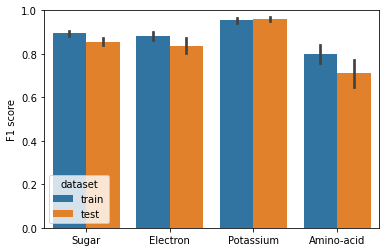

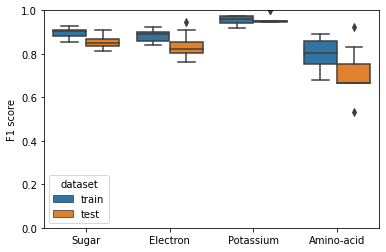

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,10,12,11,10,19,19,12,16,10,16
svc__C,10,1,1,1,10,10,10,1,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.747  0.830
Electron      0.798  0.909
Potassium     0.940  0.964
Sugar         0.889  0.910
mean          0.844  0.903

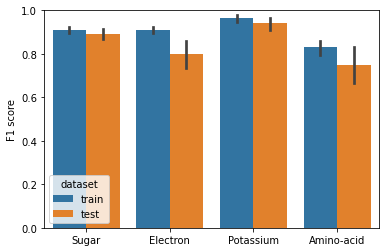

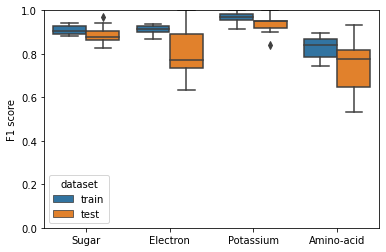

In [28]:
test_case(
    df_aac,
    labels,
    test_name="AAC",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    class_weight=["balanced"],
    C=[1, 10, 100],
)

# Eval PAAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,10,1,10,10,10,1,1,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.723  0.745
Electron      0.824  0.857
Potassium     0.925  0.918
Sugar         0.880  0.881
mean          0.838  0.850

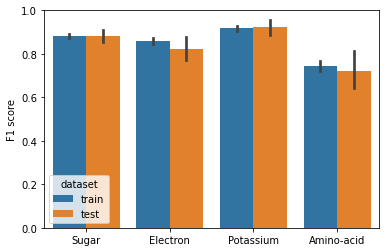

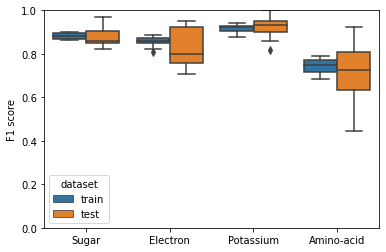

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,255,351,306,262,216,128,320,243,217,117
svc__C,10,1,10,1,10,1,10,10,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.734  0.807
Electron      0.817  0.864
Potassium     0.924  0.923
Sugar         0.858  0.902
mean          0.833  0.874

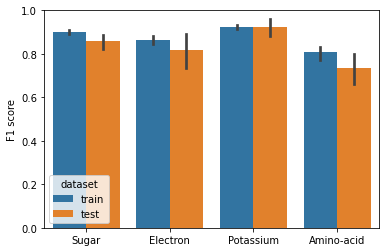

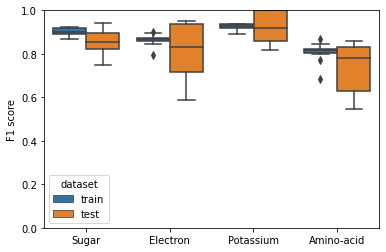

In [29]:
test_case(df_paac, labels, test_name="PAAC",decision_function_shape=["ovo"], gamma=["scale"], C=[1,10,100], class_weight=["balanced"])

# PSSM

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,all,3,3,all,all,3,all,3,3,all
pssmselector__uniref_threshold,90,all,50,all,all,all,all,90,all,all
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.944  0.945
Electron      0.980  0.977
Potassium     0.995  0.986
Sugar         0.977  0.970
mean          0.974  0.969

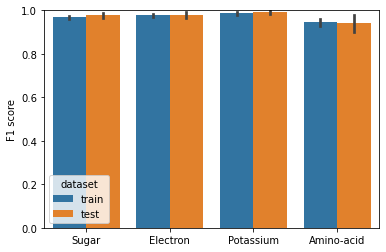

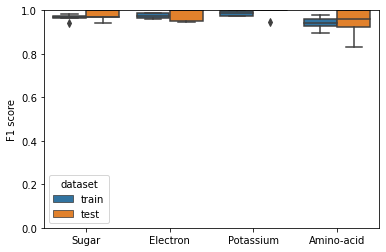

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,all,3,3,3,3,3,3,3,3,3
pssmselector__uniref_threshold,50,all,all,all,all,50,50,50,50,50
selectkbest__k,341,321,331,251,331,201,341,171,261,141
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.956  0.962
Electron      0.943  0.977
Potassium     0.970  0.984
Sugar         0.974  0.979
mean          0.961  0.975

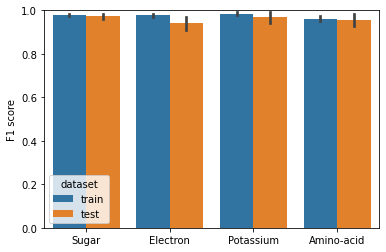

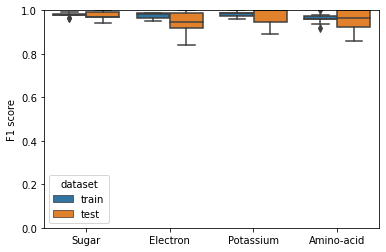

In [30]:
test_case(
    df_pssm,
    labels,
    test_name="PSSM",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    C=[1, 10, 100],
    class_weight=["balanced"],
    feature_transformer="pssm",
    select_k_steps=10,
    max_k_to_select=400,
)

# Combined

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,all,all,all,all,all,all,all,all,all,all
pssmselector__uniref_threshold,all,50,50,50,all,50,all,all,all,50
svc__C,10,10,10,10,10,10,1,10,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.928  0.911
Electron      0.956  0.974
Potassium     0.984  0.985
Sugar         0.950  0.952
mean          0.954  0.955

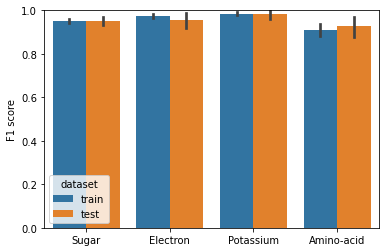

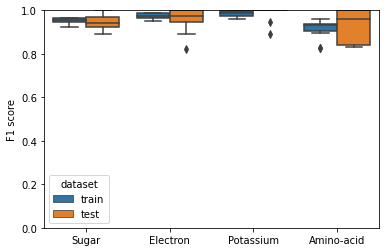

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,3,3,all,all,3,all,3,3,3,3
pssmselector__uniref_threshold,50,all,50,50,all,50,50,all,50,50
selectkbest__k,241,341,391,271,351,211,261,201,261,181
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.965  0.945
Electron      0.938  0.969
Potassium     0.975  0.985
Sugar         0.971  0.970
mean          0.962  0.967

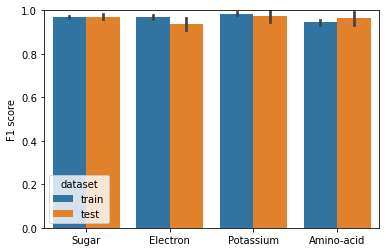

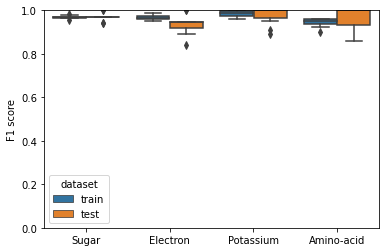

In [31]:
test_case(
    pd.concat([df_aac, df_paac, df_pssm], axis=1),
    labels,
    test_name="Combined",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    C=[1, 10, 100],
    class_weight=["balanced"],
    feature_transformer="pssm",
    select_k_steps=10,
    max_k_to_select=400
)


## Conclusion

Removing the additional electron outliers improves the model evaluation scores for the AAC feature, while the PAAC feature performs slightly worse. The PSSM feature remains largely unchanged, with mean F1 scores only differing by 0.01-0.00. The latter is also the case for the combined feature.
